In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
        
        
import os
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model, load_model
from keras.layers import BatchNormalization, Dropout, LeakyReLU, Dense, Flatten, Activation, ReLU, UpSampling2D,PReLU,UpSampling3D
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D
from keras.layers.pooling import MaxPooling2D, MaxPooling3D, GlobalMaxPooling2D, GlobalAveragePooling2D,GlobalAveragePooling3D
from keras.layers.merge import concatenate, add, multiply, average
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
import matplotlib.pyplot as plt
import time
from IPython import display
from keras.activations import sigmoid
import glob
from tifffile import imwrite

In [ ]:
def stack_generator(GT_dr,low_dr, fr_start,fr_end):
    path_gt = GT_dr+'/*.tif'
    path_low = low_dr+'/*.tif'
    image_gt = imread(sorted(glob.glob(path_gt))).astype(np.float32)
    image_low = imread(sorted(glob.glob(path_low))).astype(np.float32)
#     image_gt = np.moveaxis(image_gt,1,2)
#     image_low = np.moveaxis(image_low,1,2)

    

    if len(image_gt.shape)==4:
        image_gt = np.reshape(image_gt,(image_gt.shape[0],image_gt.shape[1],1,image_gt.shape[2],image_gt.shape[3]))
        image_low = np.reshape(image_low,(image_low.shape[0],image_low.shape[1],1,image_low.shape[2],image_low.shape[3]))

    print(image_gt.shape)
#     for i in range(len(image_gt)):
#         for j in range(image_gt.shape[2]):
#             image_gt[i,:,j,:,:] = image_gt[i,:,j,:,:]/image_gt[i,:,j,:,:].max()
#             image_low[i,:,j,:,:] = image_low[i,:,j,:,:]/image_low[i,:,j,:,:].max()

# #     for i in range(len(image_gt)):
#         for j in range(image_gt.shape[1]):
#             image_gt[i,j,:,:,:] = image_gt[i,j,:,:,:]/image_gt[i,j,:,:,:].max()
#             image_low[i,j,:,:,:] = image_low[i,j,:,:,:]/image_low[i,j,:,:,:].max()
    crop_gt = image_gt[:,fr_start:fr_end,:,:,:]
    crop_low = image_low[:,fr_start:fr_end,:,:,:]
    crop_gt = np.moveaxis(crop_gt,1,-1)
    crop_low = np.moveaxis(crop_low,1,-1)
    crop_gt = np.moveaxis(crop_gt,1,-1)
    crop_low = np.moveaxis(crop_low,1,-1)
    print(crop_low.shape)
    return crop_gt,crop_low

def data_generator(gt, low, patch_size, n_patches,n_channel,threshold, ratio,fr_start,fr_end, augment=False, shuffle=False):
    m = gt.shape[0]
    img_size = gt.shape[2]
    z_depth = fr_end-fr_start
                 
    x = np.empty((m*n_patches*n_patches, patch_size, patch_size,z_depth,1), dtype=np.float32)
    y = np.empty((m*n_patches*n_patches, patch_size, patch_size,z_depth,1), dtype=np.float32)

    
    # rr = np.floor(np.linspace(0, img_size - patch_size, n_patches))
    if n_patches==1:
        rr = [0]
        cc = [0]
    else:
        rr = np.random.choice(img_size-patch_size,n_patches)
        cc = np.random.choice(img_size-patch_size,n_patches)
        rr = rr.astype(np.int32)
        cc = cc.astype(np.int32)
    # cc = rr
    count = 0
    for l in range(m):
        for j in range(n_patches):
            for k in range(n_patches):
                x[count,:,:,:,0] = low[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size,0:z_depth,n_channel]
                y[count,:,:,:,0] = gt[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size,0:z_depth,n_channel]
                count = count + 1

    if augment:
        count = x.shape[0]
        xx = np.zeros((4 * count, patch_size, patch_size,z_depth,1), dtype=np.float32)
        yy = np.zeros((4 * count, patch_size, patch_size,z_depth,1), dtype=np.float32)

        xx[0:count, :, :, :,:] = x
        xx[count:2 * count, :, :, :,:] = np.flip(x, axis=1)
        xx[2 * count:3 * count, :, :, :,:] = np.flip(x, axis=2)
        xx[3 * count:4 * count, :, :, :,:] = np.flip(x, axis=(1, 2))

        yy[0:count, :, :, :,:] = y
        yy[count:2 * count, :, :, :,:] = np.flip(y, axis=1)
        yy[2 * count:3 * count, :, :, :,:] = np.flip(y, axis=2)
        yy[3 * count:4 * count, :, :, :,:] = np.flip(y, axis=(1, 2))
    else:
        xx = x
        yy = y
        
    xxx = xx
    yyy = yy
    print(xxx.shape)

    for i in range(len(xxx)):
        xxx[i] = xxx[i]/xxx[i].max()
        yyy[i] = yyy[i]/yyy[i].max()

    aa = np.linspace(0, len(xxx) - 1, len(xxx))
    random.shuffle(aa)
    aa = aa.astype(int)

    xxs = np.empty(xxx.shape, dtype=np.float32)
    yys = np.empty(yyy.shape, dtype=np.float32)
    

    if shuffle:
        for i in range(len(xxx)):
            xxs[i] = xxx[aa[i]]
            yys[i] = yyy[aa[i]]
    else:
        xxs = xxx
        yys = yyy
            
    # Split train and valid
    ratio = ratio
    m1 = np.floor(xxs.shape[0] * ratio).astype(np.int32)
    x_train = xxs[0:m1]
    y_train = yys[0:m1]
    x_valid = xxs[m1::]
    y_valid = yys[m1::]

    print('The training set shape is:', x_train.shape)
    print('The validation set shape is:', x_valid.shape)
    return x_train, y_train, x_valid, y_valid



mse = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
def norm_mse_loss(prediction, gt):
    n_mse = mse(prediction,gt)
    norm_mse = tf.squeeze(n_mse)    
    return norm_mse


def fft_loss(prediction, gt):
    prediction = tf.transpose(prediction, perm=[0, 3, 1, 2])
    gt = tf.transpose(gt, perm=[0, 3, 1, 2])

    fft_prediction = tf.signal.fftshift(tf.signal.rfft2d(prediction))
    fft_gt = tf.signal.fftshift(tf.signal.rfft2d(gt))

    fft_prediction = tf.transpose(fft_prediction, perm=[0, 2, 3, 1])
    fft_gt = tf.transpose(fft_gt, perm=[0, 2, 3, 1])

    loss = norm_mse_loss(fft_prediction, fft_gt)
    loss = tf.cast(loss, tf.float32)
    return loss


def ssim_loss(prediction, gt):
    prediction = tf.math.reduce_max(prediction,axis=3)
    gt = tf.math.reduce_max(gt,axis=3)
    loss = 1.0 - tf.math.reduce_mean(tf.image.ssim(prediction, gt, max_val=1))
    return loss


def perceptual_loss(prediction, gt):
    prediction = tf.math.reduce_max(prediction,axis=3)
    gt = tf.math.reduce_max(gt,axis=3)
    loss = 0
    prediction = tf.image.grayscale_to_rgb(prediction)
    gt = tf.image.grayscale_to_rgb(gt)
    for m in range(len(LL)):
        vgg_prediction = inter_vgg[m](prediction)
        vgg_gt = inter_vgg[m](gt)
        loss = loss + norm_mse_loss(vgg_prediction, vgg_gt)
    return loss


def generator_loss(prediction, gt):
    norm_mse = norm_mse_loss(prediction, gt)
    sim_loss = ssim_loss(prediction,gt)
    percept_loss = perceptual_loss(prediction,gt)
    total_gen_loss = 0.84*sim_loss+0.16*norm_mse+0.01*percept_loss
    return total_gen_loss

w_init = 'glorot_uniform'
def conv_block(inputs, filters, kernel):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = LeakyReLU()(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    y = Conv3D(filters=filters, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(inputs)
    x = add([x,y])
    x = LeakyReLU()(x)
    return x


def CAB(inputs, filters_cab, filters, kernel):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = ReLU()(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    z = GlobalAveragePooling3D(data_format='channels_last', keepdims=True)(x)
    z = Conv3D(filters=filters_cab, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(z)
    z = ReLU()(z)
    z = Conv3D(filters=filters, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(z)
    z = sigmoid(z)
    z = multiply([z, x])
    z = add([z, inputs])
    return z

def RG(inputs, num_CAB, filters, filters_cab, kernel,dropout):
    x = inputs
    for i in range(num_CAB):
        x = CAB(x, filters_cab, filters, kernel)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x


def RiR(inputs, num_RG, num_RCAB, filters, filters_cab, kernel,dropout):
    x = inputs
    for i in range(num_RG):
        x = RG(x, num_RCAB, filters, filters_cab, kernel,dropout)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x

def make_RCAN(inputs, filters, filters_cab, num_RG, num_RCAB, kernel, dropout):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = RiR(x, num_RG, num_RCAB, filters, filters_cab, kernel,dropout)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    return x

def make_generator(inputs, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape, dropout):
    skip_x = []
    x = inputs
    for i,f in enumerate(filters):
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
        skip_x.append(x)
        x = MaxPooling3D((2, 2, 2))(x)

    x = conv_block(x, 2*filters[-1], kernel_shape)
    filters.reverse()
    skip_x.reverse()

    for i, f in enumerate(filters):
        x= UpSampling3D(size=(2, 2, 2), data_format='channels_last')(x)
        xs = skip_x[i]
        # xs = CAB(xs,filters_cab=4, filters= f, kernel=(3,3,3))
        x = concatenate([x, xs])
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    y = concatenate([x,inputs])
    y = make_RCAN(inputs=y, filters=num_filters, filters_cab=filters_cab, num_RG=num_RG, num_RCAB=num_RCAB,
                  kernel=kernel_shape, dropout=dropout)
    model = Model(inputs=[inputs], outputs=[y])
    return model

<tifffile.TiffFile '_6_MMStack_Pos1.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos10.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos11.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos12.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos13.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos14.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos15.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos16.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos17.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 
<tifffile.TiffFile '_6_MMStack_Pos18.ome.tif'> OME series is BinaryOnly, not an OME

(21, 32, 2, 512, 512)
(21, 512, 512, 16, 2)
(756, 128, 128, 16, 1)
The training set shape is: (756, 128, 128, 16, 1)
The validation set shape is: (0, 128, 128, 16, 1)


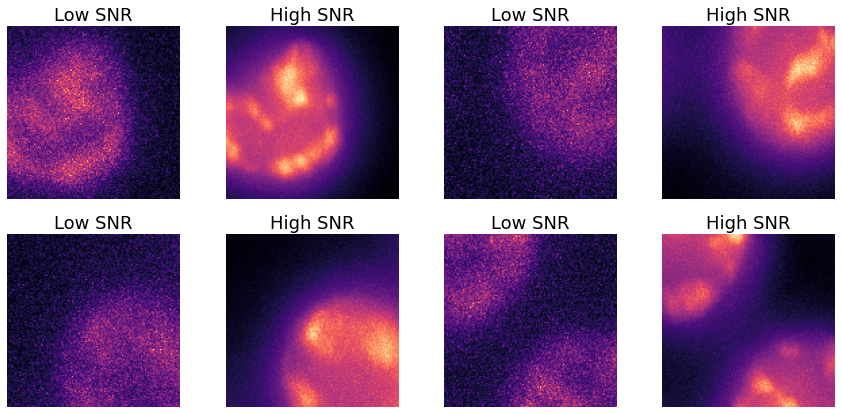

In [44]:
Ground_truth = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220714\1x ddx39B(646)-gfpson\_6" 
Low_SNR =r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220714\1x ddx39B(646)-gfpson\_1" 
frame_start =  0
frame_end =  16
patch_size =  128
n_patches =  6
n_channel =  0
threshold =  0
augment = False 
shuffle = True 
batch_size = "1" 
batch_size = int(batch_size)

GT_image_dr = Ground_truth
lowSNR_image_dr = Low_SNR


gt,low=stack_generator(GT_image_dr,lowSNR_image_dr, fr_start=frame_start,fr_end=frame_end)

x_train, y_train, x_valid, y_valid = data_generator(gt, low, patch_size, n_patches, n_channel, threshold, ratio=1.0,
                                                    fr_start=frame_start,fr_end=frame_end,augment=augment, shuffle=shuffle)

ix = random.sample(range(len(x_train)),4)
iz = 10
fig = plt.figure(figsize=(15,7))

mip_x_train=np.max(x_train,axis=3)
mip_y_train=np.max(y_train,axis=3)

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [47]:
model_save_directory = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-ddx39b-NDfilter.h5'
load_model_save_directory = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-transfer-ddx39b-NDfilter.h5'
n_epochs =  100

filters =[32,64,128,256]
num_filters = filters[0]
gen_lr = 1e-5

filters_cab=4
num_RG=4
num_RCAB=4

vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                  input_tensor=Input(shape=(patch_size,patch_size,3)))

inter_vgg = []
LL = [1,2,4,5,7,8,9,11,12,13,15,16,17]
for i in LL:
    inter_vgg.append(Model(inputs=vgg.input, outputs=vgg.get_layer(vgg.layers[i].name).output))


generator_input = Input((patch_size, patch_size,16,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3, 3),dropout=0.3)
# generator.summary()


generator.load_weights(model_save_directory)
generator.trainable= False

def make_transfer_generator(inputs, num_filters, dropout):
  x = generator(inputs,training=False)
  x = average([x,inputs])
  x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
  x = ReLU()(x)
  x = Dropout(dropout)(x)
  x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
  x = ReLU()(x)
  x = Dropout(dropout)(x)
  x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
  x = ReLU()(x)
  model = Model(inputs=[inputs],outputs=[x])
  return model


transfer_generator_input = Input((patch_size, patch_size,16,1))
transfer_generator = make_transfer_generator(transfer_generator_input,num_filters=64,dropout=0.3)
transfer_generator.load_weights(load_model_save_directory)
transfer_generator.trainable= False

In [48]:
def make_transfer_generator1(inputs, num_filters, dropout):
  x = transfer_generator(inputs,training=False)
  x = average([x,inputs])
  x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
  x = ReLU()(x)
  x = Dropout(dropout)(x)
  x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
  x = ReLU()(x)
  x = Dropout(dropout)(x)
  x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
  x = ReLU()(x)
  model = Model(inputs=[inputs],outputs=[x])
  return model


transfer_generator_input1 = Input((patch_size, patch_size,16,1))
transfer_generator1 = make_transfer_generator1(transfer_generator_input1,num_filters=64,dropout=0.3)

In [49]:
model_save_directory1 = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-ddx39b-transferlearning-2.h5'


def scheduler(epoch, lr):
    if np.mod(epoch+1,15)==0:
        return lr*0.3
    else:
        return lr

callbacks = [
    EarlyStopping(patience=100, verbose=1),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory1, verbose=1, save_best_only=True, save_weights_only=True)]



t_gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
transfer_generator1.compile(optimizer=t_gen_opt, loss=generator_loss)

In [50]:
results = transfer_generator1.fit(x=x_train,y= y_train,batch_size=batch_size, epochs=n_epochs,verbose=1, callbacks=callbacks,validation_split=0.2)

Epoch 1/100
604/604 [==============================] - ETA: 0s - loss: 0.6566
Epoch 00001: val_loss improved from inf to 0.65426, saving model to C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-ddx39b-transferlearning-2.h5
604/604 [==============================] - 143s 229ms/step - loss: 0.6566 - val_loss: 0.6543 - lr: 1.0000e-05
Epoch 2/100
604/604 [==============================] - ETA: 0s - loss: 0.5946
Epoch 00002: val_loss improved from 0.65426 to 0.58651, saving model to C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-ddx39b-transferlearning-2.h5
604/604 [==============================] - 128s 211ms/step - loss: 0.5946 - val_loss: 0.5865 - lr: 1.0000e-05
Epoch 3/100
604/604 [=

Epoch 23/100
604/604 [==============================] - ETA: 0s - loss: 0.4903
Epoch 00023: val_loss did not improve from 0.49930
604/604 [==============================] - 127s 211ms/step - loss: 0.4903 - val_loss: 0.5054 - lr: 3.0000e-06
Epoch 24/100
604/604 [==============================] - ETA: 0s - loss: 0.4901
Epoch 00024: val_loss did not improve from 0.49930
604/604 [==============================] - 127s 211ms/step - loss: 0.4901 - val_loss: 0.5008 - lr: 3.0000e-06
Epoch 25/100
604/604 [==============================] - ETA: 0s - loss: 0.4896
Epoch 00025: val_loss did not improve from 0.49930
604/604 [==============================] - 128s 211ms/step - loss: 0.4896 - val_loss: 0.5002 - lr: 3.0000e-06
Epoch 26/100
604/604 [==============================] - ETA: 0s - loss: 0.4893
Epoch 00026: val_loss did not improve from 0.49930
604/604 [==============================] - 128s 211ms/step - loss: 0.4893 - val_loss: 0.5011 - lr: 3.0000e-06
Epoch 27/100
604/604 [==================

KeyboardInterrupt: 

In [57]:
Ground_truth_test = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T-lowGFP 555nmonly_1\movie1'
Low_SNR_test = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T-lowGFP 555nmonly_1\movie1'

test_patch_size=512
frame_start=0
frame_end =  16
n_channel =  0

test_GT = Ground_truth_test
test_low = Low_SNR_test

model_save_directory1 = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-transfer-ddx39b-NDfilter.h5"
filters_cab=4
num_RG=4
num_RCAB=4

filters = [32,64,128,256]
num_filters = filters[0]




gt_test,low_test=stack_generator(test_GT,test_low, fr_start=frame_start,fr_end=frame_end)
x_test, y_test,_,_ = data_generator(gt_test, low_test, test_patch_size, n_patches=1 ,n_channel=n_channel, threshold=0, ratio=1.0,
                                                    fr_start=frame_start,fr_end=frame_end,augment=False, shuffle=False)

generator_input = Input((test_patch_size, test_patch_size,16,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3, 3),dropout=0.3)

model_save_directory1 = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-ddx39b-NDfilter.h5"
model_save_directory2 = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-transfer-ddx39b-NDfilter.h5"
model_save_directory3 = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-ddx39b-transferlearning-2.h5'

generator.load_weights(model_save_directory1)
generator.trainable= False

def make_transfer_generator(inputs, num_filters, dropout):
    x = generator(inputs,training=False)
    x = average([x,inputs])
    x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    model = Model(inputs=[inputs],outputs=[x])
    return model

transfer_generator_input = Input((test_patch_size, test_patch_size,16,1))
transfer_generator = make_transfer_generator(transfer_generator_input,num_filters=64,dropout=0.3)
transfer_generator.load_weights(model_save_directory2)
transfer_generator.trainable=False

def make_transfer_generator1(inputs, num_filters, dropout):
    x = transfer_generator(inputs,training=False)
    x = average([x,inputs])
    x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    model = Model(inputs=[inputs],outputs=[x])
    return model


transfer_generator_input1 = Input((test_patch_size, test_patch_size,16,1))
transfer_generator1 = make_transfer_generator(transfer_generator_input1,num_filters=64,dropout=0.3)
transfer_generator1.load_weights(model_save_directory3)

prediction1 = np.zeros(x_test.shape)
for i in range(len(x_test)):
    prediction1[i]= transfer_generator(x_test[i:i+1],training=False)
prediction1 = prediction1/prediction1.max()
prediction1[prediction1<0]=0

mip_x_test=np.max(x_test,axis=3)
mip_y_test=np.max(y_test,axis=3)
mip_prediction1=np.max(prediction1,axis=3)

(80, 21, 2, 512, 512)
(80, 512, 512, 16, 2)
(80, 512, 512, 16, 1)
The training set shape is: (80, 512, 512, 16, 1)
The validation set shape is: (0, 512, 512, 16, 1)


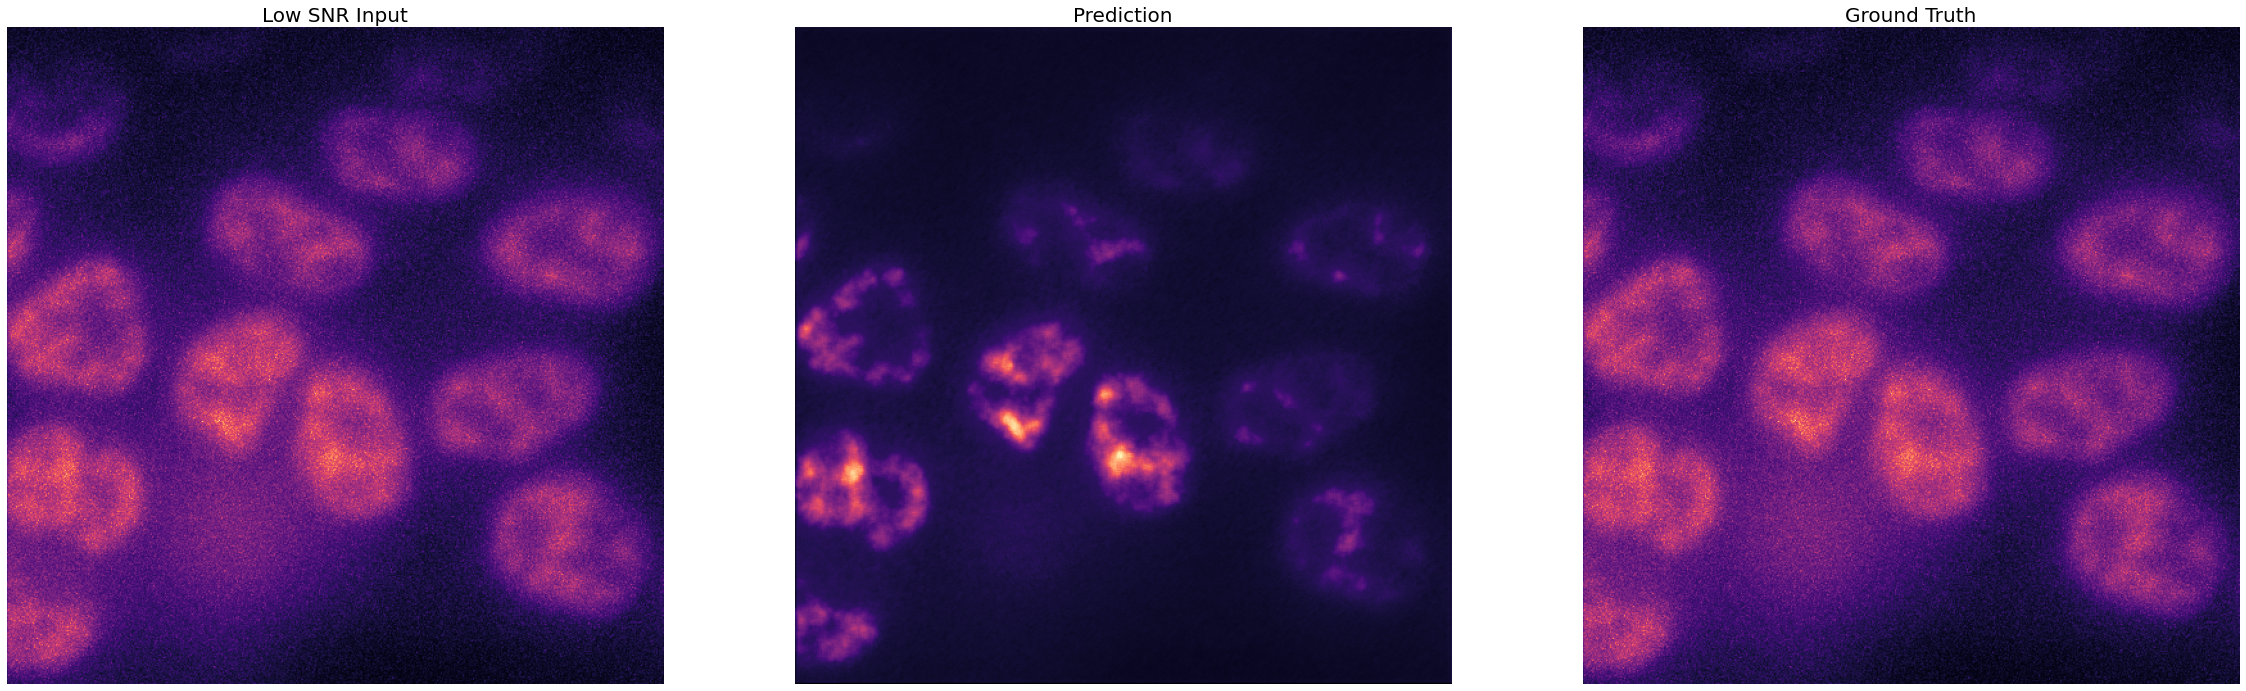

In [61]:
ix = np.random.randint(len(prediction1))
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 3, 1)
plt.imshow(mip_x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mip_prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mip_y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [62]:
save_image_dr = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1" #@param {type:"string"}


from tifffile import imwrite

pred1_test = np.moveaxis(prediction1,3,1)
X_test = np.moveaxis(x_test,3,1)
Y_test = np.moveaxis(y_test,3,1)


pred1_test = pred1_test*(2**16-1)
X_test = X_test*(2**16-1)
Y_test = Y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/prediction.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
imwrite(save_image_dr+'/x_test.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
imwrite(save_image_dr+'/y_test.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})

In [ ]:
#@title **Cell 9: Image quality assessment with NMSE, PSNR, and MS-SSIM** { form-width: "50%" }

#@markdown Directory to Save the Image Quality Assessment Results
save_parameters_dr = "/content/drive/MyDrive/WidefieldData/deconvolution/lp50/Parameters50ch1.csv" #@param {type:"string"}

def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction.astype(np.float32), gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((6,len(prediction1)))

imageq_param[0::2,:] = nmse_psnr_ssim(mip_x_test,mip_y_test)
imageq_param[1::2,:] = nmse_psnr_ssim(mip_prediction1,mip_y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
labels = ['noisy', 'prediction']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE')

bplot2 = axes[1].boxplot([imageq_param[2,:],imageq_param[3,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR')

bplot3 = axes[2].boxplot([imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM')


np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")